In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import gamma as gamma_func
from scipy.special import beta as beta_func
from scipy.integrate import quad
np.random.seed(42)
import matplotlib

from tueplots import bundles
plt.rcParams.update(bundles.icml2022())
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = 'Times new Roman'
matplotlib.rcParams['text.usetex'] = True

print(plt.rcParams['figure.figsize'])
figwidth = plt.rcParams['figure.figsize'][0]
figheight = plt.rcParams['figure.figsize'][1]
print(figheight)
print(figwidth)

[3.25, 2.0086104634371584]
2.0086104634371584
3.25


In [2]:
#functions

#change the basis, i.e. x -> t(x)

"""Transforms"""
def logit_transform(theta):
    return(np.log(theta/(1-theta)))

def logit_derivative(x):
    return(1/x + 1/(1-x))

def logistic_transform(a):
    return(1 / (1 + np.exp(-a)))

def logistic_derivative(x):
    return(logistic_transform(x) * (1- logistic_transform(x)))


def beta_pdf(x, a, b):
    nom = x ** (a-1) * (1 - x) ** (b-1)
    denom = beta_func(a, b)
    return(nom/denom)

def beta_t_logit_pdf(x, a, b):
    x_t = logistic_transform(x)
    nom = (x_t) ** (a) * (1- x_t) ** (b)
    denom = beta_func(a, b)
    return((nom/denom))

def beta_mu(a, b):
    return((a-1)/(a+b-2))

def beta_var(a, b):
    return(((a-1)*(b-1))/(a+b-2)**3)

"""transform: logit"""

def beta_t_logit_mu(a,b):
    return(np.log(a/b))

def beta_t_logit_var(a,b):
    return((a+b)/(a*b))

def logit_normal_back(x, mu, sigma):
    x_ = logit_transform(x)
    return(norm.pdf(x_, mu, sigma) * logit_derivative(x))

In [3]:
"""values"""

def plot_beta_t_logit(params, save=False, filename='beta_logit_bridge.pdf', show_back=True):

    a1, b1 = params[0] #5,1
    a2, b2 = params[1] #4,2
    a3, b3 = params[2] #8,3

    x = np.linspace(0,1, 1000 +1)
    x_t = np.linspace(-4,4, 1000 +1)

    mode1 = beta_mu(a1, b1)
    mode2 = beta_mu(a2, b2)
    mode3 = beta_mu(a3, b3)

    #plot1: normal base
    sigma1 = np.sqrt(beta_var(a1, b1))
    sigma2 = np.sqrt(beta_var(a2, b2))
    sigma3 = np.sqrt(beta_var(a3, b3))

    y1 = beta_pdf(x, a1, b1)
    y2 = beta_pdf(x, a2, b2)
    y3 = beta_pdf(x, a3, b3)

    LP_approx1 = norm.pdf(x, mode1, sigma1)
    LP_approx2 = norm.pdf(x, mode2, sigma2)
    LP_approx3 = norm.pdf(x, mode3, sigma3)

    #plot 2: transform to other base
    y1_t_logit = beta_t_logit_pdf(x_t, a1, b1)
    y2_t_logit = beta_t_logit_pdf(x_t, a2, b2)
    y3_t_logit = beta_t_logit_pdf(x_t, a3, b3)

    mode1_t_logit = beta_t_logit_mu(a1,b1)
    mode2_t_logit = beta_t_logit_mu(a2,b2)
    mode3_t_logit = beta_t_logit_mu(a3,b3)

    sigma1_t_logit = np.sqrt(beta_t_logit_var(a1, b1))
    sigma2_t_logit = np.sqrt(beta_t_logit_var(a2, b2))
    sigma3_t_logit = np.sqrt(beta_t_logit_var(a3, b3))


    LP_approx1_t_logit = norm.pdf(x_t, mode1_t_logit, sigma1_t_logit)
    LP_approx2_t_logit = norm.pdf(x_t, mode2_t_logit, sigma2_t_logit)
    LP_approx3_t_logit = norm.pdf(x_t, mode3_t_logit, sigma3_t_logit)

    #plot 3: transform back and reconstruct
    if show_back:
        y1_back = logit_normal_back(x, mode1_t_logit, sigma1_t_logit)
        y2_back = logit_normal_back(x, mode2_t_logit, sigma2_t_logit)
        y3_back = logit_normal_back(x, mode3_t_logit, sigma3_t_logit)
    
    if show_back:
        fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(2*figwidth, figheight), dpi=300)
    else:
        fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(figwidth, figheight), dpi=300)
    #plot beta distribution and LPA in the standard basis
    axs[0].plot(x, y1, '-', color='firebrick')
    axs[0].plot(x, y2, '-', color='cornflowerblue')
    axs[0].plot(x, y3, 'k-', label='$\mathcal{B}$')
    axs[0].plot(x, LP_approx1, '--', color='firebrick')
    axs[0].plot(x, LP_approx2, '--', color='cornflowerblue')
    axs[0].plot(x, LP_approx3, 'k--', label='$\mathcal{N}$')
    axs[0].set_yticklabels([])
    axs[0].set_yticks([])
    axs[0].set_xlabel('$\pi$')
    axs[0].set_ylabel('$p(\pi)$')
    axs[0].set_title('Laplace in standard basis')
    leg = axs[0].legend();
    leg.legendHandles[0].set_color('grey')
    leg.legendHandles[1].set_color('grey')

    #plot beta distribution in the transformed basis
    axs[1].plot(x_t, y1_t_logit, '-', color='firebrick')
    axs[1].plot(x_t, y2_t_logit, '-', color='cornflowerblue')
    axs[1].plot(x_t, y3_t_logit, 'k-', label='$\mathcal{B}$')
    axs[1].plot(x_t, LP_approx1_t_logit, '--', color='firebrick')
    axs[1].plot(x_t, LP_approx2_t_logit, '--', color='cornflowerblue')
    axs[1].plot(x_t, LP_approx3_t_logit, 'k--', label='$\mathcal{N}$')
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('$p(x)$')
    axs[1].set_yticklabels([])
    axs[1].set_yticks([])
    axs[1].set_title('Laplace in logit basis')
    leg = axs[1].legend();
    leg.legendHandles[0].set_color('grey')
    leg.legendHandles[1].set_color('grey')

    #plot backwards transformation of the LPA from the transformed to the standard basis
    if show_back:
        axs[2].plot(x, y1, '-', color='firebrick')
        axs[2].plot(x, y2, '-', color='cornflowerblue')
        axs[2].plot(x, y3, 'k-', label='$\mathcal{B}$')
        axs[2].plot(x, y1_back, '--', color='firebrick')
        axs[2].plot(x, y2_back, '--', color='cornflowerblue')
        axs[2].plot(x, y3_back, 'k--', label='$\mathcal{N}$')
        axs[2].set_yticklabels([])
        axs[2].set_yticks([])
        axs[2].set_xlabel('$\pi$')
        axs[2].set_ylabel('$p(\pi)$')
        axs[2].set_title('Back to standard basis')
        leg = axs[2].legend();
        leg.legendHandles[0].set_color('grey')
        leg.legendHandles[1].set_color('grey')
        

    plt.tight_layout()
    
    if save:
        plt.savefig(filename)
        
    plt.show();

/tmp/ipykernel_43389/2743297974.py:17: RuntimeWarning: invalid value encountered in sqrt
  sigma1 = np.sqrt(beta_var(a1, b1))
/tmp/ipykernel_43389/841171869.py:20: RuntimeWarning: divide by zero encountered in power
  nom = x ** (a-1) * (1 - x) ** (b-1)
/tmp/ipykernel_43389/841171869.py:7: RuntimeWarning: divide by zero encountered in true_divide
  return(np.log(theta/(1-theta)))
/tmp/ipykernel_43389/841171869.py:7: RuntimeWarning: divide by zero encountered in log
  return(np.log(theta/(1-theta)))
/tmp/ipykernel_43389/841171869.py:10: RuntimeWarning: divide by zero encountered in true_divide
  return(1/x + 1/(1-x))
/tmp/ipykernel_43389/841171869.py:46: RuntimeWarning: invalid value encountered in multiply
  return(norm.pdf(x_, mu, sigma) * logit_derivative(x))
/tmp/ipykernel_43389/2743297974.py:107: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


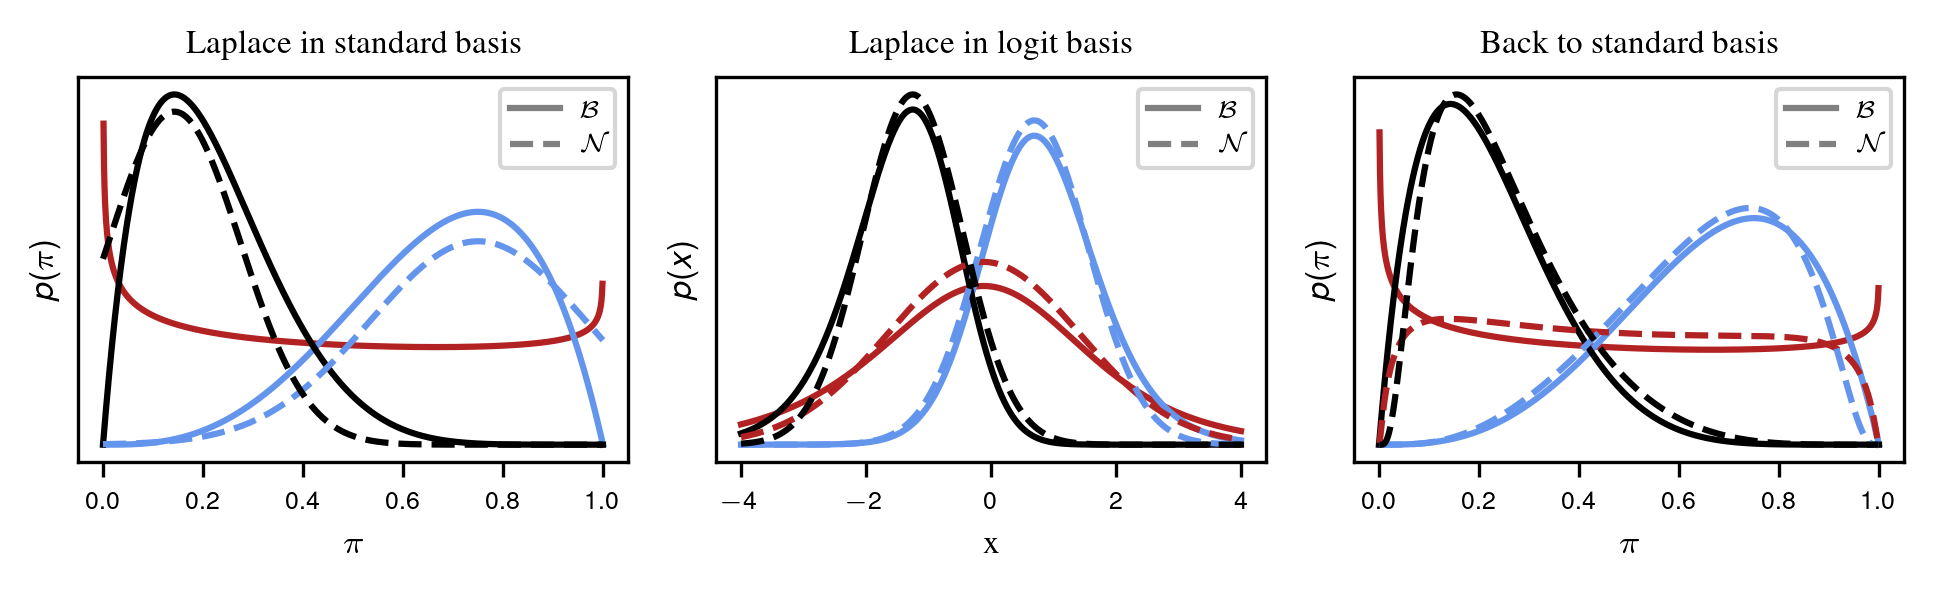

In [4]:
plot_beta_t_logit(params=[[0.8,0.9], [4,2,], [2, 7]], save=True, filename='beta_logit_bridge.pdf', show_back=True)